In [ ]:
# conexion al Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from scipy import ndimage
import dlib

In [ ]:
image_path = "/content/drive/MyDrive/cara/img.jpg"

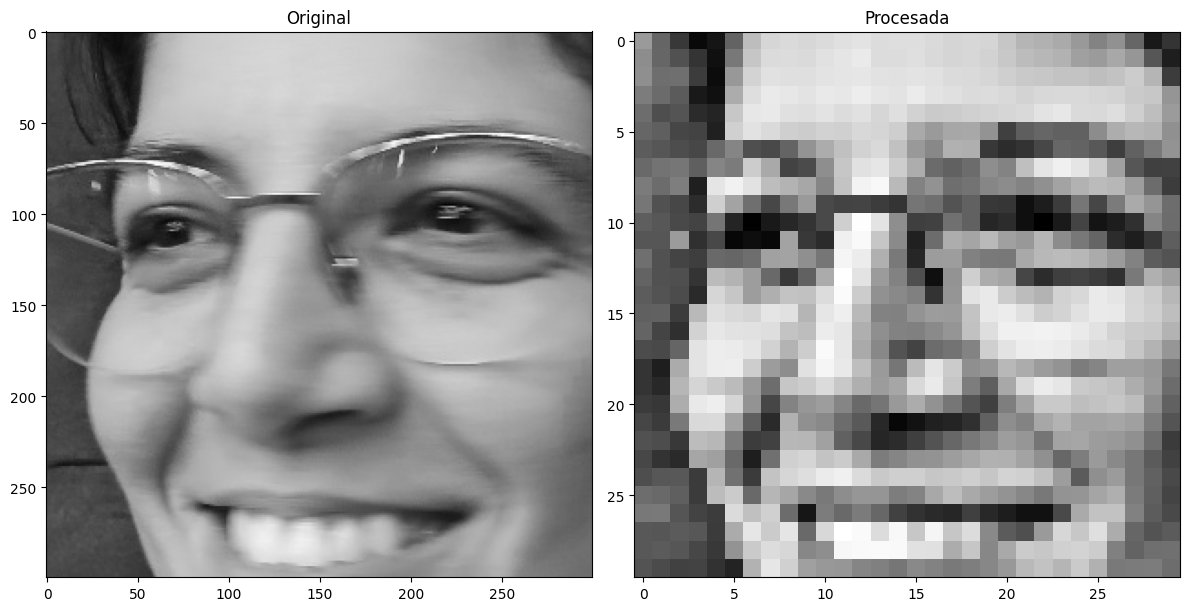

Imagen guardada en: /content/drive/MyDrive/cara/newimg.jpg


In [ ]:
def load_image(image_path):
    """Cargar imagen desde ruta"""
    img = cv2.imread(image_path)
    return img

def convert_to_grayscale(image):
    """Convertir imagen a escala de grises"""
    if len(image.shape) == 3:
        return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image

def resize_image(image, width=None, height=None):
    """Redimensionar imagen"""
    if width and height:
        return cv2.resize(image, (width, height))
    elif width:
        h, w = image.shape[:2]
        aspect_ratio = width / w
        new_height = int(h * aspect_ratio)
        return cv2.resize(image, (width, new_height))
    else:
        return image

def noise_reduction(image, kernel_size=5):
    """Reducción de ruido con filtro Gaussiano"""
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

def median_filter(image, kernel_size=5):
    """Filtro de mediana para reducción de ruido"""
    return cv2.medianBlur(image, kernel_size)

def histogram_equalization(image):
    """Ecualización de histograma global"""
    if len(image.shape) == 3:
        # Para imágenes a color, convertir a YUV y ecualizar el canal Y
        img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
        return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    else:
        # Para imágenes en escala de grises
        return cv2.equalizeHist(image)

def clahe_enhancement(image, clip_limit=2.0, grid_size=(8, 8)):
    """Ecualización de histograma adaptativo con limitación de contraste (CLAHE)"""
    if len(image.shape) == 3:
        # Para imágenes a color
        img_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(img_lab)
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=grid_size)
        l_clahe = clahe.apply(l)
        img_clahe = cv2.merge((l_clahe, a, b))
        return cv2.cvtColor(img_clahe, cv2.COLOR_LAB2BGR)
    else:
        # Para imágenes en escala de grises
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=grid_size)
        return clahe.apply(image)

def contrast_enhancement(image, alpha=1.5):
    """Mejora de contraste usando alpha"""
    if len(image.shape) == 3:
        # Para imágenes a color
        img_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        enhancer = ImageEnhance.Contrast(img_pil)
        enhanced_img = enhancer.enhance(alpha)
        return cv2.cvtColor(np.array(enhanced_img), cv2.COLOR_RGB2BGR)
    else:
        # Para imágenes en escala de grises
        return cv2.convertScaleAbs(image, alpha=alpha, beta=0)

def gamma_correction(image, gamma=1.0):
    """Corrección gamma para mejorar detalles en zonas oscuras o sobreexpuestas"""
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in range(256)]).astype(np.uint8)
    if len(image.shape) == 3:
        return cv2.LUT(image, table)
    else:
        return cv2.LUT(image, table)

def edge_detection(image, method='canny'):
    """Detección de bordes"""
    gray = convert_to_grayscale(image)
    if method == 'canny':
        return cv2.Canny(gray, 100, 200)
    elif method == 'sobel':
        sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        sobel = cv2.magnitude(sobel_x, sobel_y)
        sobel = cv2.convertScaleAbs(sobel)
        return sobel
    else:
        raise ValueError("Método no soportado. Use 'canny' o 'sobel'")

def align_face(image, landmarks):
    """Alinea la cara basándose en puntos de referencia (landmarks)
    Requiere detectar previamente los landmarks faciales con dlib o similar"""
    # Ejemplo simplificado - normalmente necesitas puntos específicos como ojos
    # Este es un placeholder - necesitarías landmarks reales
    if landmarks is None or len(landmarks) < 2:
        return image

    # Usar los ojos como referencia (simplificado)
    left_eye = landmarks[0]
    right_eye = landmarks[1]

    # Calcular ángulo para rotar
    dy = right_eye[1] - left_eye[1]
    dx = right_eye[0] - left_eye[0]
    angle = np.degrees(np.arctan2(dy, dx))

    # Rotar la imagen para alinear los ojos horizontalmente
    rows, cols = image.shape[:2]
    M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
    aligned_face = cv2.warpAffine(image, M, (cols, rows))

    return aligned_face

def background_removal(image, face_cascade_path='haarcascade_frontalface_default.xml'):
    """Elimina el fondo alrededor de la cara detectada"""
    face_cascade = cv2.CascadeClassifier(face_cascade_path)
    gray = convert_to_grayscale(image)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    # Crear máscara
    mask = np.zeros_like(image)

    for (x, y, w, h) in faces:
        # Expandir un poco el rectángulo de la cara
        expansion = int(min(w, h) * 0.2)
        x = max(0, x - expansion)
        y = max(0, y - expansion)
        w = min(image.shape[1] - x, w + 2*expansion)
        h = min(image.shape[0] - y, h + 2*expansion)

        # Llenar la máscara en el área de la cara
        if len(image.shape) == 3:
            mask[y:y+h, x:x+w] = (255, 255, 255)
        else:
            mask[y:y+h, x:x+w] = 255

    # Aplicar máscara
    result = cv2.bitwise_and(image, mask)
    return result

def data_augmentation(image):
    """Genera variaciones de la imagen para entrenamiento (data augmentation)"""
    augmented_images = []

    # Rotación
    angles = [5, -5, 10, -10]
    for angle in angles:
        rotated = ndimage.rotate(image, angle, reshape=False)
        augmented_images.append(rotated)

    # Volteo horizontal
    flipped = cv2.flip(image, 1)
    augmented_images.append(flipped)

    # Cambios de brillo
    brightness_factors = [0.7, 1.3]
    for factor in brightness_factors:
        if len(image.shape) == 3:
            hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            hsv = hsv.astype(np.float32)
            hsv[:,:,2] = hsv[:,:,2] * factor
            hsv[:,:,2] = np.clip(hsv[:,:,2], 0, 255)
            hsv = hsv.astype(np.uint8)
            bright_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
        else:
            bright_img = cv2.convertScaleAbs(image, alpha=factor, beta=0)
        augmented_images.append(bright_img)

    return augmented_images

def complete_preprocessing_pipeline(image_path, output_size=(30, 30), apply_clahe=True):
    """Pipeline completo de preprocesamiento para detectores faciales"""
    # Cargar imagen
    img = load_image(image_path)
    if img is None:
        raise ValueError(f"No se pudo cargar la imagen desde {image_path}")

    # Conversión a escala de grises (opcional dependiendo del detector)
    gray = convert_to_grayscale(img)

    # Reducción de ruido
    denoised = median_filter(gray)

    # Mejora de contraste con CLAHE
    if apply_clahe:
        enhanced = clahe_enhancement(denoised)
    else:
        enhanced = histogram_equalization(denoised)

    # Redimensionar
    resized = resize_image(enhanced, width=output_size[0], height=output_size[1])

    # Normalización adicional (escala de 0-1 para redes neuronales)
    normalized = resized.astype(np.float32) / 255.0

    return normalized

def save_image(image, output_path):
    """Guardar imagen a archivo"""
    # Si la imagen está normalizada (valores entre 0-1), convertirla a uint8
    if image.dtype == np.float32 or image.dtype == np.float64:
        if np.max(image) <= 1.0:
            image = (image * 255).astype(np.uint8)

    # Si la imagen es escala de grises pero tiene 2 dimensiones, OpenCV requiere 2D para guardar como escala de grises
    if len(image.shape) == 2:
        cv2.imwrite(output_path, image)
    else:
        # Para imágenes a color
        cv2.imwrite(output_path, image)

    return True


# Ejemplo de uso
if __name__ == "__main__":
    # Ruta de la imagen de ejemplo
    image_path = "/content/drive/MyDrive/cara/img.jpg"

    # Cargar y mostrar imagen original
    original = load_image(image_path)

    # Aplicar pipeline completo
    processed = complete_preprocessing_pipeline(image_path)

    # Visualizar resultados
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 2, 2)
    plt.title("Procesada")
    plt.imshow(processed, cmap='gray')
    plt.tight_layout()
    plt.show()

    output_path = "/content/drive/MyDrive/cara/newimg.jpg"
    save_image(processed, output_path)
    print(f"Imagen guardada en: {output_path}")

In [ ]:
# Version 2 con alineacion

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from scipy import ndimage
import dlib

Imagen guardada en: /content/drive/MyDrive/cara/newimg.jpg


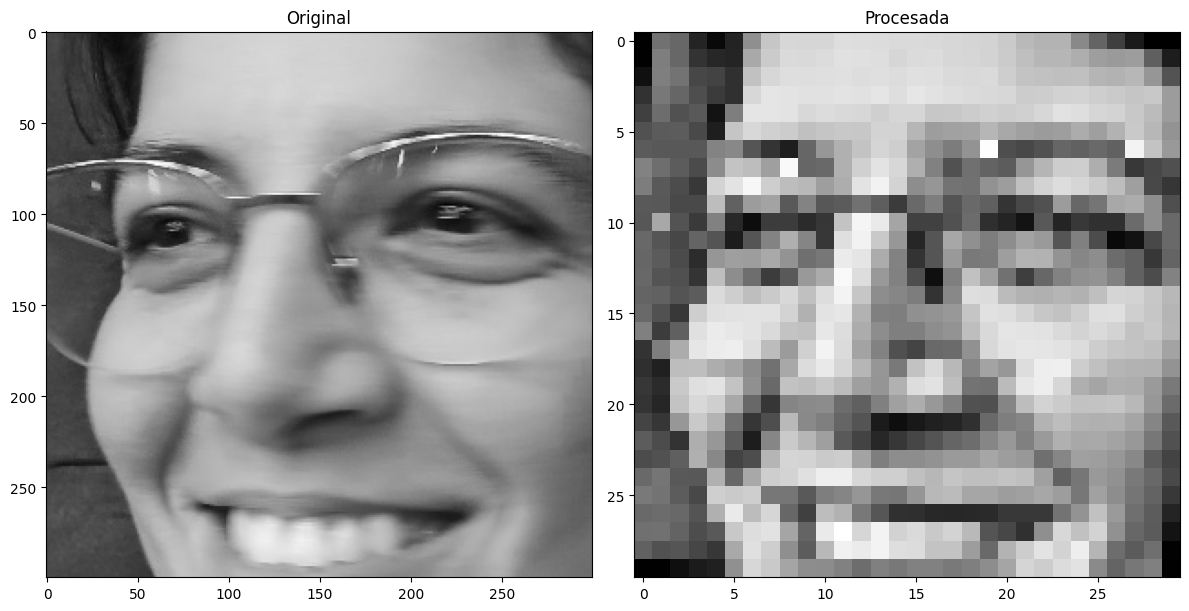

In [ ]:
def load_image(image_path):
    """Cargar imagen desde ruta"""
    img = cv2.imread(image_path)
    return img

def convert_to_grayscale(image):
    """Convertir imagen a escala de grises"""
    if len(image.shape) == 3:
        return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image

def resize_image(image, width=None, height=None):
    """Redimensionar imagen"""
    if width and height:
        return cv2.resize(image, (width, height))
    elif width:
        h, w = image.shape[:2]
        aspect_ratio = width / w
        new_height = int(h * aspect_ratio)
        return cv2.resize(image, (width, new_height))
    else:
        return image

def noise_reduction(image, kernel_size=5):
    """Reducción de ruido con filtro Gaussiano"""
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

def median_filter(image, kernel_size=5):
    """Filtro de mediana para reducción de ruido"""
    return cv2.medianBlur(image, kernel_size)

def histogram_equalization(image):
    """Ecualización de histograma global"""
    if len(image.shape) == 3:
        # Para imágenes a color, convertir a YUV y ecualizar el canal Y
        img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
        return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    else:
        # Para imágenes en escala de grises
        return cv2.equalizeHist(image)

def clahe_enhancement(image, clip_limit=2.0, grid_size=(8, 8)):
    """Ecualización de histograma adaptativo con limitación de contraste (CLAHE)"""
    if len(image.shape) == 3:
        # Para imágenes a color
        img_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(img_lab)
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=grid_size)
        l_clahe = clahe.apply(l)
        img_clahe = cv2.merge((l_clahe, a, b))
        return cv2.cvtColor(img_clahe, cv2.COLOR_LAB2BGR)
    else:
        # Para imágenes en escala de grises
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=grid_size)
        return clahe.apply(image)

def contrast_enhancement(image, alpha=1.5):
    """Mejora de contraste usando alpha"""
    if len(image.shape) == 3:
        # Para imágenes a color
        img_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        enhancer = ImageEnhance.Contrast(img_pil)
        enhanced_img = enhancer.enhance(alpha)
        return cv2.cvtColor(np.array(enhanced_img), cv2.COLOR_RGB2BGR)
    else:
        # Para imágenes en escala de grises
        return cv2.convertScaleAbs(image, alpha=alpha, beta=0)

def gamma_correction(image, gamma=1.0):
    """Corrección gamma para mejorar detalles en zonas oscuras o sobreexpuestas"""
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in range(256)]).astype(np.uint8)
    if len(image.shape) == 3:
        return cv2.LUT(image, table)
    else:
        return cv2.LUT(image, table)

def edge_detection(image, method='canny'):
    """Detección de bordes"""
    gray = convert_to_grayscale(image)
    if method == 'canny':
        return cv2.Canny(gray, 100, 200)
    elif method == 'sobel':
        sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        sobel = cv2.magnitude(sobel_x, sobel_y)
        sobel = cv2.convertScaleAbs(sobel)
        return sobel
    else:
        raise ValueError("Método no soportado. Use 'canny' o 'sobel'")

def detect_face_landmarks(image, predictor_path):
    """Detectar landmarks faciales usando dlib"""
    # Inicializar el detector de caras y el predictor de landmarks
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(predictor_path)

    # Convertir a escala de grises para la detección
    gray = convert_to_grayscale(image)

    # Detectar caras
    faces = detector(gray)

    if not faces:
        print("No se detectaron caras en la imagen")
        return None

    # Obtener landmarks de la primera cara detectada
    face = faces[0]
    landmarks = predictor(gray, face)

    # Convertir landmarks a array numpy
    landmarks_points = []
    for i in range(68):  # dlib predice 68 puntos faciales
        x = landmarks.part(i).x
        y = landmarks.part(i).y
        landmarks_points.append((x, y))

    return landmarks_points

def get_eyes_from_landmarks(landmarks):
    """Extraer coordenadas de los ojos desde landmarks"""
    if not landmarks:
        return None

    # Índices de los landmarks de los ojos
    # (según el modelo de 68 puntos de dlib)
    left_eye_indices = list(range(36, 42))
    right_eye_indices = list(range(42, 48))

    # Calcular el centro de cada ojo
    left_eye_center = np.mean(np.array([landmarks[i] for i in left_eye_indices]), axis=0).astype(np.int32)
    right_eye_center = np.mean(np.array([landmarks[i] for i in right_eye_indices]), axis=0).astype(np.int32)

    return (tuple(left_eye_center), tuple(right_eye_center))

def align_face(image, landmarks):
    """Alinear la cara basada en la posición de los ojos"""
    if not landmarks:
        return image

    # Obtener centros de los ojos
    eyes = get_eyes_from_landmarks(landmarks)
    if not eyes:
        return image

    left_eye, right_eye = eyes

    # Calcular ángulo para rotar
    dy = right_eye[1] - left_eye[1]
    dx = right_eye[0] - left_eye[0]
    angle = np.degrees(np.arctan2(dy, dx))

    # Rotar la imagen para alinear los ojos horizontalmente
    rows, cols = image.shape[:2]
    M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
    aligned_face = cv2.warpAffine(image, M, (cols, rows))

    return aligned_face

def crop_face_from_landmarks(image, landmarks, expansion_factor=0.5):
    """Recortar la cara basada en landmarks con un factor de expansión"""
    if not landmarks:
        return image

    # Convertir lista de landmarks a array numpy
    points = np.array(landmarks)

    # Obtener los límites de la cara
    x_min = np.min(points[:, 0])
    y_min = np.min(points[:, 1])
    x_max = np.max(points[:, 0])
    y_max = np.max(points[:, 1])

    # Expandir el área de recorte
    width = x_max - x_min
    height = y_max - y_min

    # Calcular expansión
    expansion_x = int(width * expansion_factor)
    expansion_y = int(height * expansion_factor)

    # Nuevos límites con expansión
    x_min = max(0, x_min - expansion_x)
    y_min = max(0, y_min - expansion_y)
    x_max = min(image.shape[1], x_max + expansion_x)
    y_max = min(image.shape[0], y_max + expansion_y)

    # Recortar la imagen
    cropped_face = image[y_min:y_max, x_min:x_max]

    return cropped_face

def background_removal(image, face_cascade_path='haarcascade_frontalface_default.xml'):
    """Elimina el fondo alrededor de la cara detectada"""
    face_cascade = cv2.CascadeClassifier(face_cascade_path)
    gray = convert_to_grayscale(image)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    # Crear máscara
    mask = np.zeros_like(image)

    for (x, y, w, h) in faces:
        # Expandir un poco el rectángulo de la cara
        expansion = int(min(w, h) * 0.2)
        x = max(0, x - expansion)
        y = max(0, y - expansion)
        w = min(image.shape[1] - x, w + 2*expansion)
        h = min(image.shape[0] - y, h + 2*expansion)

        # Llenar la máscara en el área de la cara
        if len(image.shape) == 3:
            mask[y:y+h, x:x+w] = (255, 255, 255)
        else:
            mask[y:y+h, x:x+w] = 255

    # Aplicar máscara
    result = cv2.bitwise_and(image, mask)
    return result

def data_augmentation(image):
    """Genera variaciones de la imagen para entrenamiento (data augmentation)"""
    augmented_images = []

    # Rotación
    angles = [5, -5, 10, -10]
    for angle in angles:
        rotated = ndimage.rotate(image, angle, reshape=False)
        augmented_images.append(rotated)

    # Volteo horizontal
    flipped = cv2.flip(image, 1)
    augmented_images.append(flipped)

    # Cambios de brillo
    brightness_factors = [0.7, 1.3]
    for factor in brightness_factors:
        if len(image.shape) == 3:
            hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            hsv = hsv.astype(np.float32)
            hsv[:,:,2] = hsv[:,:,2] * factor
            hsv[:,:,2] = np.clip(hsv[:,:,2], 0, 255)
            hsv = hsv.astype(np.uint8)
            bright_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
        else:
            bright_img = cv2.convertScaleAbs(image, alpha=factor, beta=0)
        augmented_images.append(bright_img)

    return augmented_images

def save_image(image, output_path):
    """Guardar imagen a archivo"""
    # Si la imagen está normalizada (valores entre 0-1), convertirla a uint8
    if image.dtype == np.float32 or image.dtype == np.float64:
        if np.max(image) <= 1.0:
            image = (image * 255).astype(np.uint8)

    # Si la imagen es escala de grises pero tiene 2 dimensiones, OpenCV requiere 2D para guardar como escala de grises
    if len(image.shape) == 2:
        cv2.imwrite(output_path, image)
    else:
        # Para imágenes a color
        cv2.imwrite(output_path, image)

    return True

def complete_preprocessing_pipeline(image_path, predictor_path, output_size=(30, 30), apply_clahe=True):
    """Pipeline completo de preprocesamiento para detectores faciales"""
    # Cargar imagen
    img = load_image(image_path)
    if img is None:
        raise ValueError(f"No se pudo cargar la imagen desde {image_path}")

    # 1. Primero reducir el ruido en la imagen original
    denoised = median_filter(img, kernel_size=3)

    # 2. Detectar landmarks faciales
    landmarks = detect_face_landmarks(denoised, predictor_path)

    # 3. Alinear la cara usando los landmarks
    if landmarks:
        aligned = align_face(denoised, landmarks)

        # 4. Recortar la cara alineada
        cropped = crop_face_from_landmarks(aligned, landmarks)
    else:
        print("No se detectaron landmarks faciales. Usando imagen completa.")
        cropped = denoised

    # 5. Conversión a escala de grises (opcional dependiendo del detector)
    gray = convert_to_grayscale(cropped)

    # 6. Mejora de contraste con CLAHE o ecualización de histograma
    if apply_clahe:
        enhanced = clahe_enhancement(gray, clip_limit=2.0)
    else:
        enhanced = histogram_equalization(gray)

    # 7. Redimensionar a tamaño estándar
    resized = resize_image(enhanced, width=output_size[0], height=output_size[1])

    # 8. Normalización adicional (escala de 0-1 para redes neuronales)
    normalized = resized.astype(np.float32) / 255.0

    return normalized

# Ejemplo de uso
if __name__ == "__main__":
    # Rutas de los archivos
    image_path = "/content/drive/MyDrive/cara/img.jpg"
    predictor_path = "/content/drive/MyDrive/shape_predictor_68_face_landmarks.dat"  # Modelo de dlib
    output_path = "/content/drive/MyDrive/cara/newimg.jpg"

    # Cargar y mostrar imagen original
    original = load_image(image_path)

    # Aplicar pipeline completo
    processed = complete_preprocessing_pipeline(image_path, predictor_path)

    # Guardar la imagen procesada
    save_image(processed, output_path)
    print(f"Imagen guardada en: {output_path}")

    # Visualizar resultados
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 2, 2)
    plt.title("Procesada")
    plt.imshow(processed, cmap='gray')
    plt.tight_layout()
    plt.show()

In [ ]:
# Corrige la posicion de la cara
# Esta es la version con la que estoy trabajando actualmente

# corrige la posicion de la cara
# Esta es la version con la que estoy trabajando actualmente

In [ ]:
#!pip install mediapipe opencv-python numpy
#!pip install --upgrade numpy tensorflow mediapipe
from google.colab.patches import cv2_imshow


Pitch: -16.06, Yaw: -10.98, Roll: -176.26


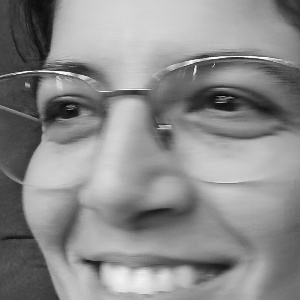

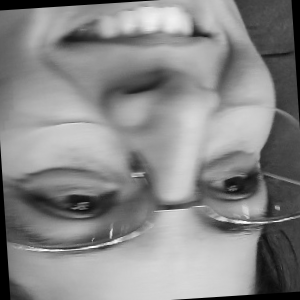

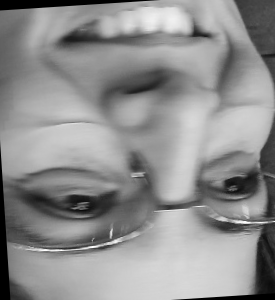

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import mediapipe as mp
import numpy as np

def get_face_pose(img):
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(img_rgb)

    if not results.multi_face_landmarks:
        return None, None

    landmarks = results.multi_face_landmarks[0].landmark

    # Índices de landmarks importantes
    idxs_pose = [33, 263, 1, 61, 291, 199]  # Ojos, nariz, boca, mentón
    idxs_bbox = [10, 152, 234, 454]          # Frente, mentón, mejilla izq, mejilla der

    # Puntos para pose estimation
    image_points = np.array([
        (landmarks[i].x * img.shape[1], landmarks[i].y * img.shape[0]) for i in idxs_pose
    ], dtype="double")

    model_points = np.array([
        (-30.0, -30.0, -30.0),  # ojo izq
        (30.0, -30.0, -30.0),   # ojo der
        (0.0, 0.0, 0.0),        # nariz
        (-20.0, 30.0, -30.0),   # boca izq
        (20.0, 30.0, -30.0),    # boca der
        (0.0, 50.0, -20.0)      # mentón
    ])

    focal_length = img.shape[1]
    center = (img.shape[1] / 2, img.shape[0] / 2)
    camera_matrix = np.array(
        [[focal_length, 0, center[0]],
         [0, focal_length, center[1]],
         [0, 0, 1]],
        dtype="double"
    )

    dist_coeffs = np.zeros((4,1))
    success, rotation_vector, translation_vector = cv2.solvePnP(model_points, image_points, camera_matrix, dist_coeffs)

    rotation_mat, _ = cv2.Rodrigues(rotation_vector)
    pose_mat = cv2.hconcat((rotation_mat, translation_vector))
    _, _, _, _, _, _, euler_angles = cv2.decomposeProjectionMatrix(pose_mat)

    pitch, yaw, roll = euler_angles.flatten()

    # Puntos para hacer bounding box
    bbox_points = np.array([
        (landmarks[i].x * img.shape[1], landmarks[i].y * img.shape[0]) for i in idxs_bbox
    ], dtype="int")

    return (pitch, yaw, roll), bbox_points

def rotar_imagen(img, roll):
    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)

    M = cv2.getRotationMatrix2D(center, -roll, 1.0)
    rotated = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_LINEAR)

    return rotated, M

def recortar_cara(rotated_img, bbox_points, M):
    # Aplicar la misma rotación a los puntos de la bbox
    ones = np.ones((bbox_points.shape[0], 1))
    points_ones = np.hstack([bbox_points, ones])
    bbox_rotated = (M @ points_ones.T).T

    x_min = int(np.min(bbox_rotated[:,0]))
    y_min = int(np.min(bbox_rotated[:,1]))
    x_max = int(np.max(bbox_rotated[:,0]))
    y_max = int(np.max(bbox_rotated[:,1]))

    # Agregar margen (opcional)
    margen = 20
    x_min = max(x_min - margen, 0)
    y_min = max(y_min - margen, 0)
    x_max = min(x_max + margen, rotated_img.shape[1])
    y_max = min(y_max + margen, rotated_img.shape[0])

    cara_recortada = rotated_img[y_min:y_max, x_min:x_max]
    return cara_recortada

# ------------------------------------------------------
# Ejemplo de uso
# ------------------------------------------------------
img = cv2.imread("/content/drive/MyDrive/cara/img.jpg")

pose, bbox_points = get_face_pose(img)

if pose:
    pitch, yaw, roll = pose
    print(f"Pitch: {pitch:.2f}, Yaw: {yaw:.2f}, Roll: {roll:.2f}")

    rotated_img, M = rotar_imagen(img, roll)
    face_crop = recortar_cara(rotated_img, bbox_points, M)

    # Mostrar resultados
    cv2_imshow(img)
    cv2_imshow(rotated_img)
    cv2_imshow(face_crop)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
else:
    print("No se detectó rostro.")


# Version que procesa todas las imagenes de la carpeta origen

In [ ]:
import os
import cv2
from google.colab.patches import cv2_imshow
import mediapipe as mp
import numpy as np

def get_face_pose(img):
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(img_rgb)

    if not results.multi_face_landmarks:
        return None, None

    landmarks = results.multi_face_landmarks[0].landmark

    # Índices de landmarks importantes
    idxs_pose = [33, 263, 1, 61, 291, 199]  # Ojos, nariz, boca, mentón
    idxs_bbox = [10, 152, 234, 454]          # Frente, mentón, mejilla izq, mejilla der

    # Puntos para pose estimation
    image_points = np.array([
        (landmarks[i].x * img.shape[1], landmarks[i].y * img.shape[0]) for i in idxs_pose
    ], dtype="double")

    model_points = np.array([
        (-30.0, -30.0, -30.0),  # ojo izq
        (30.0, -30.0, -30.0),   # ojo der
        (0.0, 0.0, 0.0),        # nariz
        (-20.0, 30.0, -30.0),   # boca izq
        (20.0, 30.0, -30.0),    # boca der
        (0.0, 50.0, -20.0)      # mentón
    ])

    focal_length = img.shape[1]
    center = (img.shape[1] / 2, img.shape[0] / 2)
    camera_matrix = np.array(
        [[focal_length, 0, center[0]],
         [0, focal_length, center[1]],
         [0, 0, 1]],
        dtype="double"
    )

    dist_coeffs = np.zeros((4,1))
    success, rotation_vector, translation_vector = cv2.solvePnP(model_points, image_points, camera_matrix, dist_coeffs)

    rotation_mat, _ = cv2.Rodrigues(rotation_vector)
    pose_mat = cv2.hconcat((rotation_mat, translation_vector))
    _, _, _, _, _, _, euler_angles = cv2.decomposeProjectionMatrix(pose_mat)

    pitch, yaw, roll = euler_angles.flatten()

    # Puntos para hacer bounding box
    bbox_points = np.array([
        (landmarks[i].x * img.shape[1], landmarks[i].y * img.shape[0]) for i in idxs_bbox
    ], dtype="int")

    return (pitch, yaw, roll), bbox_points

def rotar_imagen(img, roll):
    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)

    # Check if roll indicates upside-down image
    if abs(roll) > 90:  # You might need to adjust this threshold
        roll += 180  # Rotate by an additional 180 degrees

    M = cv2.getRotationMatrix2D(center, -roll, 1.0)
    rotated = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_LINEAR)

    return rotated, M

def recortar_cara(rotated_img, bbox_points, M):
    # Aplicar la misma rotación a los puntos de la bbox
    ones = np.ones((bbox_points.shape[0], 1))
    points_ones = np.hstack([bbox_points, ones])
    bbox_rotated = (M @ points_ones.T).T

    x_min = int(np.min(bbox_rotated[:,0]))
    y_min = int(np.min(bbox_rotated[:,1]))
    x_max = int(np.max(bbox_rotated[:,0]))
    y_max = int(np.max(bbox_rotated[:,1]))

    # Agregar margen (opcional)
    margen = 20
    x_min = max(x_min - margen, 0)
    y_min = max(y_min - margen, 0)
    x_max = min(x_max + margen, rotated_img.shape[1])
    y_max = min(y_max + margen, rotated_img.shape[0])

    cara_recortada = rotated_img[y_min:y_max, x_min:x_max]
    return cara_recortada


def process_images_in_folder(origen_folder, destino_folder, predictor_path):
    """
    Processes all images in the origen folder and its subfolders,
    applying face pose correction and saving the results to the destino folder.
    """
    for subject_folder in os.listdir(origen_folder):
        subject_path = os.path.join(origen_folder, subject_folder)
        if os.path.isdir(subject_path):
            # Create corresponding subfolder in destino
            destino_subject_path = os.path.join(destino_folder, subject_folder)
            os.makedirs(destino_subject_path, exist_ok=True)

            for filename in os.listdir(subject_path):
                if filename.endswith(('.jpg', '.jpeg', '.png')): # Adjust extensions if needed
                    image_path = os.path.join(subject_path, filename)
                    img = cv2.imread(image_path)

                    pose, bbox_points = get_face_pose(img)

                    if pose:
                        pitch, yaw, roll = pose
                        print(f"Processing: {image_path} - Pitch: {pitch:.2f}, Yaw: {yaw:.2f}, Roll: {roll:.2f}")

                        rotated_img, M = rotar_imagen(img, roll)
                        face_crop = recortar_cara(rotated_img, bbox_points, M)

                        # Construct output path
                        output_path = os.path.join(destino_subject_path, filename)
                        cv2.imwrite(output_path, face_crop)

                    else:
                        print(f"No face detected in: {image_path}")


# --- Example Usage ---
origen_folder = "/content/drive/MyDrive/redimensionadas"  # Your source folder
destino_folder = "/content/drive/MyDrive/caras_procesadas2"  # Your destination folder
predictor_path = "/content/drive/MyDrive/shape_predictor_68_face_landmarks.dat"

process_images_in_folder(origen_folder, destino_folder, predictor_path)
print("Processing complete!")




--stop

# ------------------------------------------------------
# Ejemplo de uso
# ------------------------------------------------------
img = cv2.imread("/content/drive/MyDrive/cara/img.jpg")

pose, bbox_points = get_face_pose(img)

if pose:
    pitch, yaw, roll = pose
    print(f"Pitch: {pitch:.2f}, Yaw: {yaw:.2f}, Roll: {roll:.2f}")

    rotated_img, M = rotar_imagen(img, roll)
    face_crop = recortar_cara(rotated_img, bbox_points, M)

    # Mostrar resultados
    cv2_imshow(img)
    cv2_imshow(rotated_img)
    cv2_imshow(face_crop)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
else:
    print("No se detectó rostro.")


Processing: /content/drive/MyDrive/redimensionadas/Gustavo/IMG_6347.jpeg - Pitch: -7.74, Yaw: -9.57, Roll: -175.33
Processing: /content/drive/MyDrive/redimensionadas/Gustavo/IMG_6349.jpeg - Pitch: -20.99, Yaw: 5.80, Roll: 177.21
Processing: /content/drive/MyDrive/redimensionadas/Gustavo/IMG_6348.jpeg - Pitch: 0.07, Yaw: -24.54, Roll: -177.88
Processing: /content/drive/MyDrive/redimensionadas/Federico/1742907849997.jpg - Pitch: 50.11, Yaw: 11.60, Roll: 3.28
Processing: /content/drive/MyDrive/redimensionadas/Federico/IMG_8667.jpeg - Pitch: -16.10, Yaw: 9.21, Roll: 172.29
Processing: /content/drive/MyDrive/redimensionadas/Federico/IMG_8666.jpeg - Pitch: -26.99, Yaw: -0.43, Roll: 176.52
Processing: /content/drive/MyDrive/redimensionadas/Federico/20250321_140311.jpg - Pitch: -7.13, Yaw: -13.09, Roll: -178.86
Processing: /content/drive/MyDrive/redimensionadas/Federico/IMG_1252.jpeg - Pitch: -28.56, Yaw: 1.42, Roll: 175.67
Processing: /content/drive/MyDrive/redimensionadas/Federico/IMG_6797.j

NameError: name 'stop' is not defined